<a href="https://colab.research.google.com/github/Hannahhhhhhhhhhhh/Learning-with-d2l/blob/main/HousePrice_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! nvidia-smi

Fri Jul 22 13:45:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None): 
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): 
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)


## 演示数据集

In [ ]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)


## 竞赛数据集

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

train_data = pd.read_csv('/content/drive/MyDrive/CaliforniaHousePriceData/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/CaliforniaHousePriceData/test.csv')

print(train_data.shape)
print(test_data.shape)

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

(47439, 41)
(31626, 40)


In [4]:
all_features.columns

Index(['Address', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
       'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

In [5]:
all_features.describe()

,Sold Price,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
count,4.743900e+04,77123.000000,5.607600e+04,73655.000000,66137.000000,7.518700e+04,77398.000000,77398.000000,70330.000000,70572.000000,50786.000000,50788.000000,71281.000000,71890.000000,7.274200e+04,71856.000000,7.906500e+04,4.952000e+04,79065.000000
mean,1.296050e+06,1962.739572,3.690859e+05,2.391311,2.100292,4.216193e+03,1.861844,1.690767,5.710138,1.141035,5.249931,1.710690,6.160057,2.349060,6.855887e+05,8665.371883,1.138944e+06,6.966890e+05,93163.363423
std,1.694452e+06,129.066775,1.996199e+07,1.161958,0.942378,6.433812e+05,13.738636,13.676751,2.071209,2.184128,2.022063,2.321382,1.979861,3.297097,1.031404e+06,12823.211966,2.173946e+06,1.009869e+06,2088.330724
min,1.005000e+05,0.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,-15.000000,-15.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,85611.000000
25%,5.650000e+05,1950.000000,5.087000e+03,2.000000,2.000000,1.200000e+03,0.000000,0.000000,4.000000,0.300000,3.000000,0.700000,5.000000,0.800000,2.250730e+05,3024.000000,4.800000e+05,2.790000e+05,91360.000000
50%,9.600000e+05,1972.000000,6.753000e+03,2.000000,2.000000,1.586000e+03,2.000000,2.000000,6.000000,0.600000,5.000000,1.100000,6.000000,1.400000,4.535080e+05,5912.000000,7.950000e+05,4.950000e+05,94025.000000
75%,1.525000e+06,1992.000000,1.063200e+04,3.000000,2.000000,2.167000e+03,2.000000,2.000000,7.000000,1.000000,7.000000,1.900000,8.000000,2.400000,8.179620e+05,10451.000000,1.299000e+06,8.200000e+05,95051.000000
max,9.000000e+07,9999.000000,2.217378e+09,24.000000,24.000000,1.764164e+08,3109.000000,3109.000000,10.000000,57.200000,10.000000,57.200000,10.000000,73.900000,4.590000e+07,999999.000000,4.025320e+08,9.000000e+07,96155.000000


## 数据预处理

In [6]:
# 去掉冗余数据
redundant_cols = ['Address', 'Summary', 'City', 'State']
for c in redundant_cols:
    del test_data[c], train_data[c]

# 数据预处理
large_vel_cols = ['Lot', 'Total interior livable area', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price']
for c in large_vel_cols:
    train_data[c] = np.log(train_data[c]+1)
    test_data[c] = np.log(test_data[c]+1)

In [7]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(len(numeric_features))

19


In [8]:
for in_object in all_features.dtypes[all_features.dtypes=='object'].index:
    print(in_object.ljust(20),len(all_features[in_object].unique()))

Address              78875
Summary              77775
Type                 174
Heating              2660
Cooling              911
Parking              9913
Bedrooms             278
Region               1259
Elementary School    3568
Middle School        809
High School          922
Flooring             1740
Heating features     1763
Cooling features     596
Appliances included  11290
Laundry features     3031
Parking features     9695
Listed On            2815
Last Sold On         6949
City                 1122
State                3


In [9]:
features = list(numeric_features)
# 加上类别数相对较少的Type
features.extend(['Type','Bedrooms','State'])
all_features = all_features[features]

In [10]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
print(all_features.shape)
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(79065, 22)
(79065, 475)


In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

In [12]:
print(train_features.shape, test_features.shape, train_labels.shape)

torch.Size([47439, 475]) torch.Size([31626, 475]) torch.Size([47439, 1])


## 训练

In [21]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,256),nn.Linear(256,128),nn.Linear(128,1))
    return net

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [22]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse2.229356, 验证log rmse2.357383
折2，训练log rmse5.508805, 验证log rmse5.125440
折3，训练log rmse0.387337, 验证log rmse0.418248
折4，训练log rmse6.326754, 验证log rmse6.450419
折5，训练log rmse2.723491, 验证log rmse2.875735
5-折验证: 平均训练log rmse: 3.435149, 平均验证log rmse: 3.445445


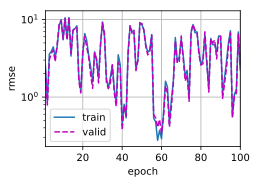

In [23]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [7]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 714 kB/s 
     |████████████████████████████████| 61 kB 8.9 MB/s 
     |████████████████████████████████| 15.7 MB 62.1 MB/s 
     |████████████████████████████████| 9.9 MB 56.7 MB/s 
     |████████████████████████████████| 11.2 MB 55.5 MB/s 
     |████████████████████████████████| 944 kB 62.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    

In [8]:
!pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albu